In [2]:
import numpy as np
import pandas as pdcoding
import gzip
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse
idata = SOMToolBox_Parse("datasets/iris/iris.vec").read_weight_file()
weights = SOMToolBox_Parse("datasets\\iris\\iris.wgt.gz").read_weight_file()

In [4]:
#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position = np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)

In [5]:
import panel as pn
import holoviews as hv
from holoviews import opts
"""hv.extension('bokeh')

hithist = hv.Image(HitHist(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None) 
um = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) 
sdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)   

hv.Layout([hithist.relabel('HitHist').opts(cmap='kr'), 
           um.relabel('U-Matrix').opts(cmap='jet'), sdh.relabel('SDH').opts(cmap='viridis')])"""

"hv.extension('bokeh')\n\nhithist = hv.Image(HitHist(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None) \num = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) \nsdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)   \n\nhv.Layout([hithist.relabel('HitHist').opts(cmap='kr'), \n           um.relabel('U-Matrix').opts(cmap='jet'), sdh.relabel('SDH').opts(cmap='viridis')])"

In [6]:
def rectangular_topology_dist(map_size):
    """Rectangular topology distance function.

    Returns the distance function between two units on a rectangular map (Manhattan distance).

    Parameters
    ----------
    map_size : tuple (height, width)
        SOM height and width.

    Returns
    -------
    dist_fun : (k : int, l : int) => int
        distance function between units k and l on the map.
    """
    def dist_fun(k, l):
        return abs(k // map_size[1] - l // map_size[1]) + abs(k % map_size[1] - l % map_size[1])
    return dist_fun


def topographic_product(dist_fun, som):
    """Topographic product.

    Parameters
    ----------
    dist_fun : function (k : int, l : int) => int
        distance function between units k and l on the map.
    som : array, shape = [n_units, dim]
        SOM code vectors.

    Returns
    -------
    tp : float
        topographic product (tp < 0 when the map is too small, tp > 0 if it is too large)

    References
    ----------
    Bauer, H. U., & Pawelzik, K. R. (1992). Quantifying the Neighborhood Preservation of Self-Organizing Feature Maps.
    """
    n_units = som.shape[0]
    original_d = euclidean_distances(som) + 1e-16
    original_knn = np.argsort(original_d, axis=1)
    map_d = np.array([[dist_fun(j, k)
                      for k in range(n_units)]
                      for j in range(n_units)]) + 1e-16
    map_knn = np.argsort(map_d, axis=1)
    # compute Q1 (n_units x n_units-1 matrix)
    q1 = np.array([[np.divide(original_d[j, map_knn[j, k]], original_d[j, original_knn[j, k]])
                   for k in range(1, n_units)]
                   for j in range(n_units)])
    # compute Q2 (n_units x n_units-1 matrix)
    q2 = np.array([[np.divide(map_d[j, map_knn[j, k]], map_d[j, original_knn[j, k]])
                   for k in range(1, n_units)]
                   for j in range(n_units)])
    # compute P3 (n_units x n_units-1 matrix)
    p3 = np.array([[np.prod([(q1[j, l] * q2[j, l])**(1/(2*k)) for l in range(k)])
                   for k in range(1, n_units)]
                   for j in range(n_units)])
    # combine final result (float)
    t = np.sum(np.log(p3)) / (n_units * (n_units - 1))
    topographic_dict = {
        "q1": q1,
        "q2": q2,
        "p3": p3,
        "t": t
    }
    
    return topographic_dict

The code for the visualization is based on the SOMperf Project by FlorentF9 (https://github.com/FlorentF9/SOMperf). This GitHub repository offers a simple implementation of the calculation of the topographic product. The calculation start by calculating the pairwise euclidean distance of the som and also the originial k nearest neighbors from the input space. Afterwards both values are calculated for each node of the som. Then the calculation of the q1, q2 and p3 values based on the Paper from Bauer, H. U., & Pawelzik, K. R. takes place. The topographic product is then calculated also based on the mentioned paper. The function also makes use of the rectangular_topology_dist function. This function is used to calculate the distance (manhattan distance) between the nodes of the nodes of the som. 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
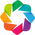

In [8]:
import numpy as np
import panel as pn
import holoviews as hv
from holoviews import opts

# Enable Bokeh backend
hv.extension('bokeh')

def som_visualization(map_size, topographic_dict):
    topographic_prod_size = topographic_dict['q1'].shape[0]

    q1 = topographic_dict['q1']
    q2 = topographic_dict['q2']
    p3 = topographic_dict['p3']

    # Q1 Values
    q1_img = hv.Image(
        q1
    ).opts(
        title='Q1 Values',
        xaxis=None,
        yaxis=None,
    )

    # Q2 Values
    q2_img = hv.Image(
        q2
    ).opts(
        title='Q2 Values',
        xaxis=None,
        yaxis=None,
    )

    # P3 Values
    p3_img = hv.Image(
        p3
    ).opts(
        title='P3 Values',
        xaxis=None,
        yaxis=None,
    )
    
    # reshape the data by flatten each node to display on the som size
    q1_reshaped = topographic_dict['q1'].flatten()[:topographic_prod_size].reshape(map_size[0], map_size[1])
    q2_reshaped = topographic_dict['q2'].flatten()[:topographic_prod_size].reshape(map_size[0], map_size[1])
    p3_reshaped = topographic_dict['p3'].flatten()[:topographic_prod_size].reshape(map_size[0], map_size[1])

    # Q1 Values reshaped
    q1_reshaped = hv.Image(
        q1_reshaped
    ).opts(
        title='Q1 Values reshaped',
        xaxis=None,
        yaxis=None,
    )

    # Q2 Values reshaped
    q2_reshaped = hv.Image(
        q2_reshaped
    ).opts(
        title='Q2 Values reshaped',
        xaxis=None,
        yaxis=None,
    )

    # P3 Values reshaped
    p3_reshaped = hv.Image(
        p3_reshaped
    ).opts(
        title='P3 Values reshaped',
        xaxis=None,
        yaxis=None,
    )

    top_row = hv.Layout([q1_img, q2_img, p3_img]).cols(3)
    bottom_row = hv.Layout([q1_reshaped, q2_reshaped, p3_reshaped]).cols(3)

    dashboard = pn.Column(
        top_row,  # First row
        bottom_row  # Second row
    )
    
    dashboard.show()

This function is used for the visualization of the distortion in input space, distortion in output space and the mean of the two as topographic product (p3). The first three displayed maps are heatmaps that where not further reshaped. The three representations are trimmed down to the mean value of all different correspondings values. With that the different representations can be fit on the original size of the used som. 

In [10]:
import numpy as np

def test_q1_size():
    map_size = (10, 10)
    weights = np.random.rand(10 * 10, 4)  # 10x10 grid, 4 features each
    weights_reshaped = weights.reshape(map_size[0]*map_size[1], -1)
    topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights_reshaped)
    q1_dim = topographic_vals["q1"].shape
    assert q1_dim == (map_size[0]*map_size[1], map_size[0]*map_size[1] - 1), "Shape of Q1 does not fit to calculation"
    print("Q1 size test passed!")

def test_q2_size():
    map_size = (10, 10)
    weights = np.random.rand(10 * 10, 4)  # 10x10 grid, 4 features each
    weights_reshaped = weights.reshape(map_size[0]*map_size[1], -1)
    topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights_reshaped)
    q2_dim = topographic_vals["q2"].shape
    assert q2_dim == (map_size[0]*map_size[1], map_size[0]*map_size[1] - 1), "Shape of Q2 does not fit to calculation"
    print("Q2 size test passed!")

def test_p3_size():
    map_size = (10, 10)
    weights = np.random.rand(10 * 10, 4)  # 10x10 grid, 4 features each
    weights_reshaped = weights.reshape(map_size[0]*map_size[1], -1)
    topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights_reshaped)
    p3_dim = topographic_vals["p3"].shape
    assert p3_dim == (map_size[0]*map_size[1], map_size[0]*map_size[1] - 1), "Shape of P does not fit to calculation"
    print("P3 size test passed!")

# test functionality with a non-squared som
def test_unsquare_som_performance():
    map_size = (20, 10)
    weights = np.random.rand(20 * 10, 4)  # 100x60 grid, 4 features each
    weights_reshaped = weights.reshape(map_size[0]*map_size[1], -1)
    topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights_reshaped)
    assert isinstance(topographic_vals["t"], float), f"Unexpected topographic product value"
    print("Non square SOM performance test passed!")

# check if topographic product is actually a float 
def test_complete_topographic_product():
    map_size = (10, 10)
    weights = np.random.rand(10 * 10, 4)  # 10x10 grid, 4 features each
    weights_reshaped = weights.reshape(map_size[0]*map_size[1], -1)
    topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights_reshaped)
    assert isinstance(topographic_vals["t"], float), f"Topographic product should be a float, got {type(T)}"
    print("Complete topographic product test passed!")

def run_tests():
    test_q1_size()
    test_q2_size()
    test_p3_size()
    test_unsquare_som_performance()
    test_complete_topographic_product()

run_tests()

Q1 size test passed!
Q2 size test passed!
P3 size test passed!
Non square SOM performance test passed!
Complete topographic product test passed!


This cell is used to test the functionality of the calculation of the topographic product. In the first place all dimensions of the distortions are tested to ensure that they can be displayed correctly. Afterwards the performance of an unsquared is tested to ensure the functionality of a non-squared one. At last a simple test on a calculation of a topographic product is tested and checked if the returned value is actually a numerical value. 

In [12]:
from minisom import MiniSom
chainlink_data = SOMToolBox_Parse("datasets\\chainlink\\chainlink.vec").read_weight_file()
clusters_data = SOMToolBox_Parse("datasets\\10clusters\\10clusters.vec").read_weight_file()

In [13]:
small_som_chainlink = MiniSom(10, 10, 3)
small_som_chainlink.train(chainlink_data['arr'], 1000)

map_size = (10,10)
small_som_chainlink_weights = small_som_chainlink.get_weights()
weights = small_som_chainlink_weights.reshape(map_size[0]*map_size[1], -1)
topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights)
som_visualization(map_size, topographic_vals)

Launching server at http://localhost:57455


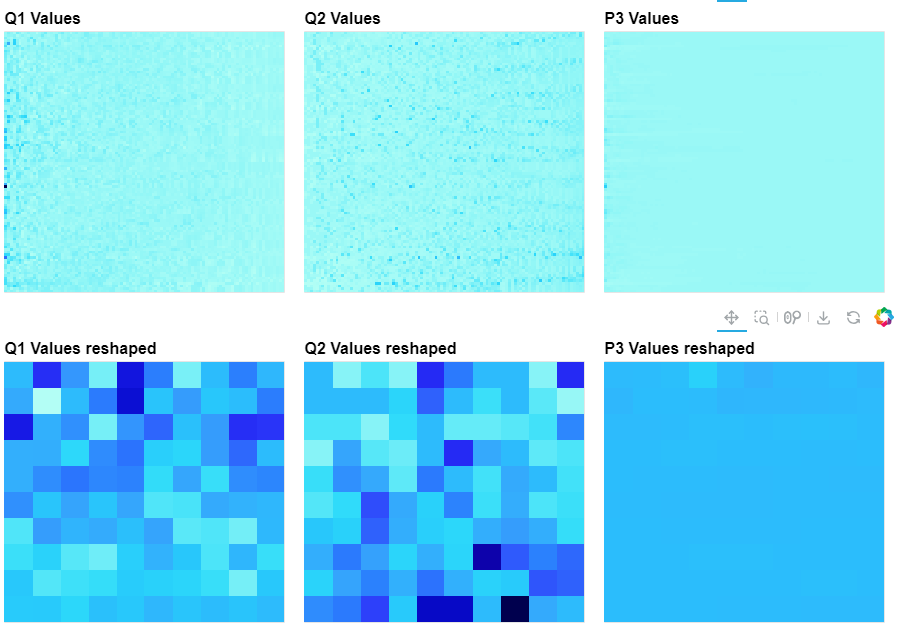

In [15]:
small_som_clusters = MiniSom(10, 10, 10)
small_som_clusters.train(clusters_data['arr'], 1000)

map_size = (10,10)
small_som_clusters_weights = small_som_clusters.get_weights()
weights = small_som_clusters_weights.reshape(map_size[0]*map_size[1], -1)
topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights)
som_visualization(map_size, topographic_vals)

Launching server at http://localhost:57456


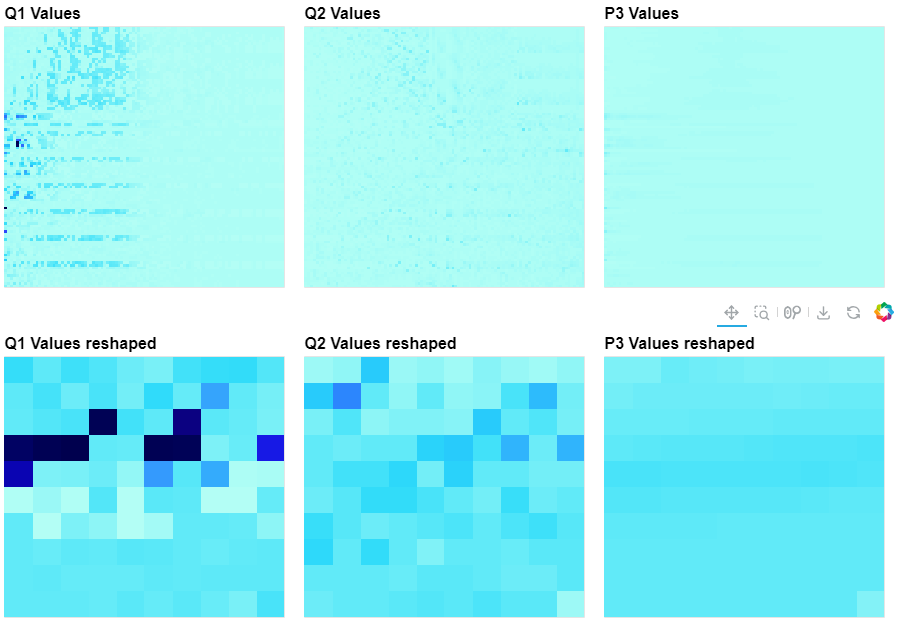

In [17]:
large_som_chainlink = MiniSom(100, 60, 3)
large_som_chainlink.train(chainlink_data['arr'], 3)

map_size = (100, 60)
large_som_chainlink_weights = large_som_chainlink.get_weights()
weights = large_som_chainlink_weights.reshape(map_size[0]*map_size[1], -1)
topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights)
som_visualization(map_size, topographic_vals)

Launching server at http://localhost:58565


In [18]:
large_som_clusters = MiniSom(100, 60, 10)
large_som_clusters.train(clusters_data['arr'], 3)

map_size = (100, 60)
large_som_clusters_weights = large_som_clusters.get_weights()
weights = large_som_clusters_weights.reshape(map_size[0]*map_size[1], -1)
topographic_vals = topographic_product(rectangular_topology_dist(map_size), weights)
som_visualization(map_size, topographic_vals)

Launching server at http://localhost:56326


### Evaluation for 3/4:

Neighborhood-Radius: describes how many neighboring units (neurons) react to the input

With an increasing size of the Neighborhood-Radius the influence of the neighbor units gets bigger resulting in an increased global structure and a smoother representation. A downside of this is that the convergence of the som takes longer than with a smalle radius. 

Learning rate: describes the amount of change of the neurons during the training process

Generally speaking a higher learning rate results in a faster change of neuron values but may shoot over the optimum because of the high change of the neuron weights during training. An upside of this is the faster convergence compared to a smaller learning rate. A pro of a smaller learning rate is a better convergence and more stable results.

Overall the neighborhood radius and also the learning rate should both be adapted during the training. Both parameters should be set to higher values in the beginning of the training and then slowly decreased to smaller values. 